In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/fake_news_content_detection_weekend_hackathon_20/Participants_Data_WH20.zip

--2020-09-13 19:27:01--  https://machinehack-be.s3.amazonaws.com/fake_news_content_detection_weekend_hackathon_20/Participants_Data_WH20.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.64.56
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.64.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565484 (552K) [application/zip]
Saving to: ‘Participants_Data_WH20.zip.2’

Participants_Data_W 100%[===================>] 552.23K   458KB/s    in 1.2s    

2020-09-13 19:27:03 (458 KB/s) - ‘Participants_Data_WH20.zip.2’ saved [565484/565484]



In [ ]:
!unzip Participants_Data_WH20.zip

Archive:  Participants_Data_WH20.zip
replace Participants_Data_WH20/sample submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Participants_Data_WH20/sample submission.csv  
  inflating: __MACOSX/Participants_Data_WH20/._sample submission.csv  
  inflating: Participants_Data_WH20/Test.csv  
  inflating: __MACOSX/Participants_Data_WH20/._Test.csv  
  inflating: Participants_Data_WH20/Train.csv  
  inflating: __MACOSX/Participants_Data_WH20/._Train.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install rfpimp
!pip install catboost
from sklearn.metrics import mean_absolute_error,accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split,StratifiedShuffleSplit
from rfpimp import *
from tqdm import tqdm
from catboost import *
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from fastai.text import *
from fastai.imports import *
from fastai.text import *
from fastai import *
path = Path('/content/Participants_Data_WH20/')
path.ls()
%matplotlib inline

from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.metrics import *
from catboost import CatBoostClassifier
import nltk
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

In [ ]:
train = pd.read_csv('Participants_Data_WH20/Train.csv')
test = pd.read_csv('Participants_Data_WH20/Test.csv')
sub=pd.read_csv('Participants_Data_WH20/sample submission.csv')

In [ ]:
train.head(5)

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


In [ ]:
test.head(5)

,Text,Text_Tag
0,Building a wall on the U.S.-Mexico border will...,immigration
1,Wisconsin is on pace to double the number of l...,jobs
2,Says John McCain has done nothing to help the ...,"military,veterans,voting-record"
3,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti..."
4,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti..."


In [ ]:
train['Text_Tag']=train['Text_Tag'].fillna(method='bfill')

In [ ]:
df=train.append(test,ignore_index=True)

In [ ]:
df['exam']=df['Text']+df['Text_Tag']

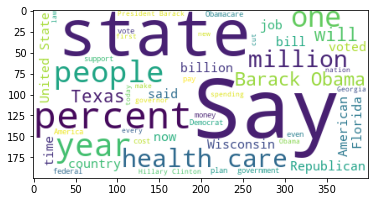

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(df['Text']))
plt.imshow(wc)

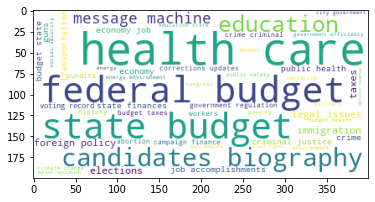

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(df['Text_Tag']))
plt.imshow(wc)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
cvec = TfidfVectorizer(max_features=10000, norm = 'l1', lowercase=True, smooth_idf=False, sublinear_tf=False, ngram_range=(1,4), tokenizer=TreebankWordTokenizer().tokenize)
df_info = pd.DataFrame(cvec.fit_transform(df['Text']).todense())
df_info.columns = ['Text_Top_' + str(c) for c in df_info.columns]
df = pd.concat([df, df_info], axis=1)

In [ ]:
m=[]
c=0
for i in df['Text_Tag']:
  x=i.strip().split(',')
  for i in x:
    if i in m:
      pass
    else:
      m.append(i)
len(m)

144

In [ ]:
x = df['Text_Tag'].str.split(',').apply(Series, 1)
x=x.fillna('zero')

In [ ]:
df['Test_tag_0']=x[0]
df['Test_tag_1']=x[1]
df['Test_tag_2']=x[2]

In [ ]:
import string
punctuation=string.punctuation
df['numerics'] = df['Text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['upper'] = df['Text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df['punctuation_count'] = df['Text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))

In [ ]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['Text'] = df['Text'].apply(clean_text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import string
punctuation=string.punctuation
df['word_count']=df['Text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['Text'].str.len()
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['Text'].apply(lambda x: avg_word(x))
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['Text'].apply(lambda x: len([x for x in x.split() if x in stop]))

df['word_density'] = df['char_count'] / (df['word_count']+1)


In [ ]:
j=[]
for i in df['Text']:
  j.append(len(i))
df['len']=j
j=[]
for i in df['Text_Tag']:
  j.append(len(i))
df['Text_Tag_len']=j

In [ ]:
df['Text_Tag_word_count']=df['Text_Tag'].apply(lambda x: len(str(x).split(",")))

In [ ]:
from textblob import TextBlob
df['polarity'] = df.apply(lambda x: TextBlob(x['Text']).sentiment.polarity, axis=1)
df['subjectivity'] = df.apply(lambda x: TextBlob(x['Text']).sentiment.subjectivity, axis=1)

In [ ]:
del df['Text']
del df['Text_Tag']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Test_tag_0'] = le.fit_transform(df['Test_tag_0'])
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Test_tag_1'] = le.fit_transform(df['Test_tag_1'])
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Test_tag_2'] = le.fit_transform(df['Test_tag_2'])

In [ ]:
train = df[df['Labels'].isnull()==False]
test = df[df['Labels'].isnull()==True]
del test['Labels']

# roberta

In [ ]:
df = pd.concat([train, test]).reset_index()

In [ ]:
word_embeddings = SentenceTransformer('roberta-large-nli-stsb-mean-tokens').encode(df.exam)

In [ ]:
word_embeddings = pd.DataFrame(data=word_embeddings)
word_embeddings.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.801883,0.511661,0.272893,0.441221,0.463626,0.331225,1.214009,-0.217106,-1.140216,0.282758,-0.975920,-1.419697,0.257403,0.735011,-0.292063,-1.615715,0.647413,-0.322343,0.234186,-0.757872,-0.895169,-0.723663,-1.180914,-1.058129,0.107446,-0.295619,-0.030847,-0.401780,-0.584536,-0.051050,0.399052,-0.852768,0.208489,0.085622,-1.578175,-0.531752,0.323392,-0.784022,-1.496740,-0.645368,...,-0.302775,-0.282882,-0.077527,0.095239,-1.039294,-0.090900,-0.083196,0.266914,-0.021078,-0.222481,0.660045,-0.989475,-0.335516,-1.918082,-0.517694,0.555794,0.570587,-0.506178,0.027676,0.710457,-0.016272,0.049623,1.238207,-0.305549,-0.579361,-1.146383,0.463412,-0.265080,-1.001871,1.359082,0.188887,0.456408,0.904822,0.546142,0.018217,0.618712,-0.471544,0.772706,-0.635814,-0.327403
1,-0.065657,0.937802,1.334514,0.252647,0.394274,-0.679673,-1.148281,-0.144142,0.803068,-0.548930,0.411720,-0.266884,-0.238542,-0.182003,-0.235795,-0.725057,-0.645538,-0.224459,0.307029,-0.041149,0.300311,0.410458,-0.641302,0.083911,-0.996734,0.115280,-0.810110,-1.124860,0.300343,-1.099083,0.574459,0.336379,-0.708229,-0.272053,0.623871,-0.752064,-0.442056,0.020547,1.474250,-0.719255,...,0.458236,0.177231,-0.166351,-0.651130,0.737427,-0.232309,-0.295287,-0.292511,-0.728357,-1.053575,0.950193,-1.327629,-0.453734,-0.291895,0.790298,-0.293105,-1.869508,-0.359968,-0.203410,-0.864321,0.410455,-0.794275,-0.518989,0.027805,-0.924352,-1.544062,-0.777510,0.868630,-1.569012,0.082370,-0.778777,1.001443,-0.548175,1.132127,-0.192424,0.405482,-0.349500,-0.508972,-1.854057,0.005836
2,-1.164357,-0.756229,-0.253541,-1.411964,0.155720,-0.192438,-0.593016,1.088283,-0.449267,0.442307,-0.480819,-0.706141,-1.049064,1.032293,0.528963,-0.105588,1.321583,0.921122,0.694375,0.951267,-0.199727,-1.014720,-1.735588,-0.202829,-0.537754,0.220931,0.235791,-0.199278,-0.624736,-0.434325,-1.203798,-1.079593,0.613384,1.088589,-0.942701,-1.217841,0.338625,-0.038331,-1.181492,0.413882,...,0.527184,-0.454275,-0.551556,0.553771,0.398279,1.730838,-0.321381,-0.387629,0.268391,-0.206483,0.678006,0.613707,-0.578744,1.792660,-0.546838,0.317672,0.098957,0.240118,-1.008545,-0.062218,-1.190836,0.472364,0.104265,-1.138334,0.543779,0.254874,-0.040282,0.654161,-0.671741,1.429626,0.619683,1.391288,-0.416964,0.170247,-0.953644,0.235321,-0.963672,-1.880567,0.216914,-0.230296
3,0.600805,0.505085,0.603590,0.511605,0.775266,-0.093028,0.290949,-0.318093,-0.437430,0.000395,-0.157860,1.707440,-0.377165,0.479488,-0.379611,-1.269664,-0.253589,0.001603,-0.821549,-1.291210,-0.075261,0.797197,1.674821,-0.465363,1.328702,-0.341335,-0.524673,-0.435174,0.837961,-0.684701,-1.316985,-0.401352,-0.583970,0.428655,-0.697539,0.679382,-0.747504,-0.830236,-0.373260,-0.192130,...,-0.201329,-0.406040,-0.187641,-0.489907,-0.223781,0.547441,0.741735,0.828914,-0.946390,-0.166673,0.527885,-0.671121,-1.212912,-0.777085,-0.556243,0.016882,0.026109,-0.821794,-1.126272,-0.728123,-0.608869,-1.651639,1.132287,-0.130393,0.659210,-0.361745,0.981023,-0.330118,-1.503566,1.950964,0.249735,-0.106412,-0.412975,0.098251,0.806665,-0.225918,-0.068621,1.446685,0.781926,-0.499272


In [ ]:
from sklearn.decomposition import PCA
pca = pd.DataFrame(data=PCA(10).fit_transform(word_embeddings), columns=[f'pca{i}' for i in range(1,11)])

In [ ]:
df['Length'] = df['exam'].apply(len)
df = pd.concat([df.drop('exam', axis=1), word_embeddings, pca], axis=1)
df.head(4)

In [ ]:
train_df = df[df.Labels.notnull()]
test_df = df[df.Labels.isnull()]

In [ ]:
X, y = train_df.drop(['index','Labels'], axis=1), train_df.Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:

model_cat = CatBoostClassifier(od_type='Iter', iterations=10000, task_type='GPU')
model_cat.fit(X_train, y_train.astype(int),
              eval_set=(X_test, y_test.astype(int)),
              early_stopping_rounds=100,
)

Learning rate set to 0.048112
0:	learn: 1.7869498	test: 1.7874637	best: 1.7874637 (0)	total: 322ms	remaining: 53m 35s
1:	learn: 1.7816338	test: 1.7831967	best: 1.7831967 (1)	total: 459ms	remaining: 38m 12s
2:	learn: 1.7768357	test: 1.7786288	best: 1.7786288 (2)	total: 591ms	remaining: 32m 49s
3:	learn: 1.7717630	test: 1.7747588	best: 1.7747588 (3)	total: 727ms	remaining: 30m 16s
4:	learn: 1.7676934	test: 1.7710834	best: 1.7710834 (4)	total: 826ms	remaining: 27m 30s
5:	learn: 1.7634968	test: 1.7683797	best: 1.7683797 (5)	total: 960ms	remaining: 26m 38s
6:	learn: 1.7593287	test: 1.7651303	best: 1.7651303 (6)	total: 1.09s	remaining: 25m 58s
7:	learn: 1.7556977	test: 1.7627134	best: 1.7627134 (7)	total: 1.22s	remaining: 25m 28s
8:	learn: 1.7523903	test: 1.7596689	best: 1.7596689 (8)	total: 1.36s	remaining: 25m 7s
9:	learn: 1.7487078	test: 1.7573211	best: 1.7573211 (9)	total: 1.5s	remaining: 24m 55s
10:	learn: 1.7458543	test: 1.7550200	best: 1.7550200 (10)	total: 1.61s	remaining: 24m 24s
11

In [ ]:
'''
importance = pd.DataFrame(data=model_cat.feature_importances_, index=X_train.columns, columns=['imp']).sort_values(by='imp',ascending=False)
imp_feat = importance[importance['imp'] > 0.05].index
model_cat = CatBoostClassifier(od_type='Iter', iterations=10000, task_type='GPU')
model_cat.fit(X_train[imp_feat], y_train.astype(int),
              eval_set=(X_test[imp_feat], y_test.astype(int)),
              early_stopping_rounds=100,
            )
'''

In [ ]:

prediction = model_cat.predict_proba(test_df[X_train.columns])
submission = pd.DataFrame(prediction, columns=[0,1,2,3,4,5])
submission.to_csv('besteverfast.csv', index=False)
submission

,0,1,2,3,4,5
0,0.171008,0.218362,0.181632,0.209074,0.071280,0.148645
1,0.106396,0.227640,0.208951,0.268742,0.045782,0.142488
2,0.154546,0.175131,0.187505,0.170408,0.066446,0.245964
3,0.205239,0.207912,0.235903,0.082429,0.187969,0.080549
4,0.136303,0.278379,0.208374,0.149577,0.120952,0.106416
...,...,...,...,...,...,...
1262,0.092328,0.132188,0.305973,0.282382,0.023690,0.163438
1263,0.137895,0.168007,0.143368,0.201016,0.099118,0.250596
1264,0.207074,0.218520,0.217951,0.119526,0.147768,0.089162
1265,0.175669,0.193117,0.189824,0.252734,0.064966,0.123690
